In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA, KernelPCA
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import r2_score
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Homework 5

In [14]:
def visualise_clusters(X, labels, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50, alpha=0.5)
    plt.title(title)
    plt.colorbar()
    plt.show()

In [19]:
clear_dataset = pd.read_csv('clear_dataset.csv')
Y_target = clear_dataset['gap']
clear_dataset.drop(columns=['gap','smiles'], inplace=True)

In [10]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(clear_dataset)

kpca = KernelPCA(n_components=2, kernel='rbf')
X_kpca = kpca.fit_transform(clear_dataset)

In [16]:
# K-means
kmeans = KMeans(n_clusters=3, random_state=15)
pca_kmeans_labels = kmeans.fit_predict(X_pca)

kmeans = KMeans(n_clusters=3, random_state=15)
kpca_kmeans_labels = kmeans.fit_predict(X_kpca)

# DBSCAN
dbscan = DBSCAN(eps=0.3, min_samples=5)
pca_dbscan_labels = dbscan.fit_predict(X_pca)

dbscan = DBSCAN(eps=0.3, min_samples=5)
kpca_dbscan_labels = dbscan.fit_predict(X_kpca)

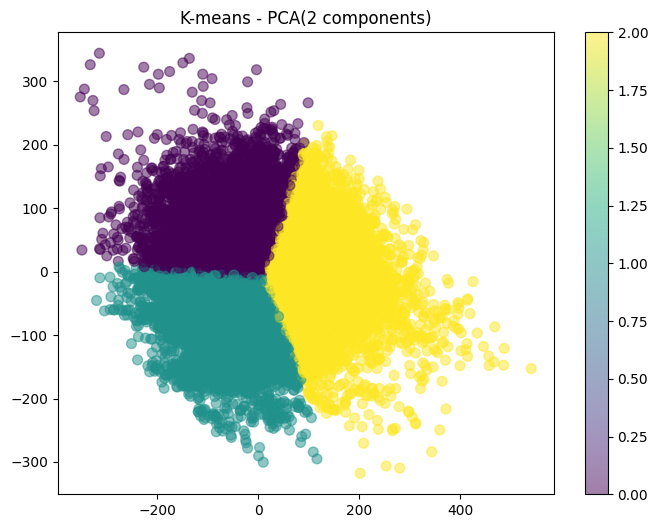

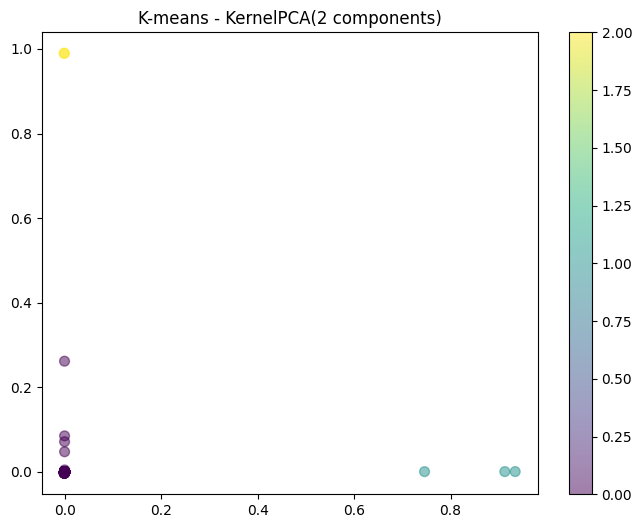

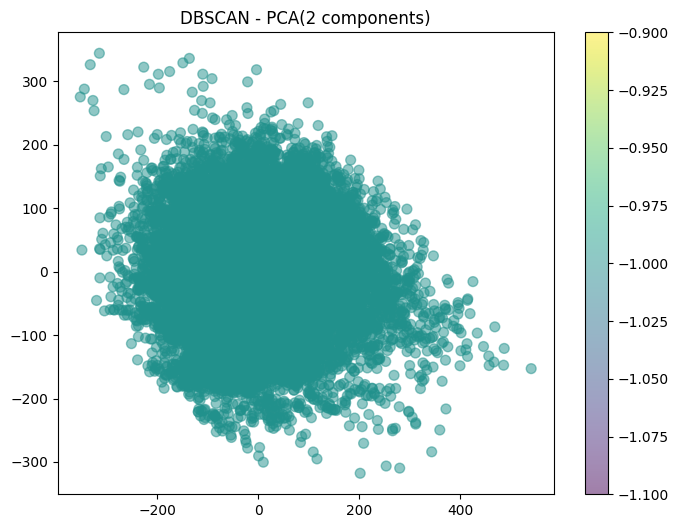

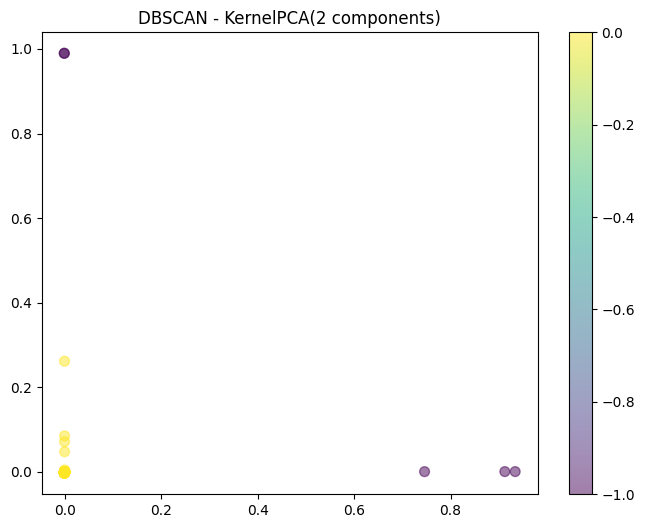

In [17]:
visualise_clusters(X_pca, pca_kmeans_labels, 'K-means - PCA(2 components)')
visualise_clusters(X_kpca, kpca_kmeans_labels, 'K-means - KernelPCA(2 components)')
visualise_clusters(X_pca, pca_dbscan_labels, 'DBSCAN - PCA(2 components)')
visualise_clusters(X_kpca, kpca_dbscan_labels, 'DBSCAN - KernelPCA(2 components)')

In [20]:
print("Adjusted rand score - K-Means-PCA(2 components):", adjusted_rand_score(Y_target, pca_kmeans_labels))
print("Adjusted rand score - DBSCAN-PCA(2 components):", adjusted_rand_score(Y_target, pca_dbscan_labels))
print("Adjusted rand score - K-Means-KernelPCA(2 components):", adjusted_rand_score(Y_target, kpca_kmeans_labels))
print("Adjusted rand score - DBSCAN-KernelPCA(2 components):", adjusted_rand_score(Y_target, kpca_dbscan_labels))

Adjusted rand score - K-Means-PCA(2 components): 0.00010443673215406203
Adjusted rand score - DBSCAN-PCA(2 components): 0.0
Adjusted rand score - K-Means-KernelPCA(2 components): 6.937147602928997e-08
Adjusted rand score - DBSCAN-KernelPCA(2 components): 6.933606936620827e-08


c:\Users\User\Documents\Conda\envs\trotsenko_env\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
c:\Users\User\Documents\Conda\envs\trotsenko_env\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
c:\Users\User\Documents\Conda\envs\trotsenko_env\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
c:\Users\User\Documents\Conda\envs\trotsenko_env\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received 

# Homework 6

In [26]:
pca = PCA(n_components=48)
X_pca = pca.fit_transform(clear_dataset)
X_pca = pd.DataFrame(X_pca)

In [22]:
models = [('Random Forest', RandomForestRegressor()),
          ('Gradient Boosting', GradientBoostingRegressor()),
          ('LightGBM', LGBMRegressor()),
          ('XGBoost', XGBRegressor())]

In [ ]:
results = {}
for model in models:
    r2_scores = []
    y_pred_all = []

    kf = KFold(n_splits=10, shuffle=True, random_state=15)
    for train_index, test_index in kf.split(X_pca):
        X_train, X_test = X_pca.iloc[train_index], X_pca.iloc[test_index]
        y_train, y_test = Y_target.iloc[train_index], Y_target.iloc[test_index]

        model[1].fit(X_train, y_train)
        y_pred = model[1].predict(X_test)
        r2 = r2_score(y_test, y_pred)
        r2_scores.append(r2)
        y_pred_all.extend(y_pred)

    results[model[0]] = {
        'r2_scores': r2_scores,
        'y_pred': y_pred_all
    }

In [ ]:
plt.figure(figsize=(10, 6))
for model_name, result in results.items():
    plt.scatter(Y_target, result['y_pred'], label=model_name)
plt.plot([Y_target.min(), Y_target.max()], [Y_target.min(), Y_target.max()], 'k--', lw=2)
plt.xlabel('Real')
plt.ylabel('Predicted')
plt.title('R2 Plot (Predicted vs. Real)')
plt.legend()
plt.show()

In [ ]:
for model_name, result in results.items():
    print(f'{model_name}: Mean R2 Score = {np.mean(result["r2_scores"])}')

Лучшая модель - LGBMRegressor()

In [ ]:
best_model = LGBMRegressor()
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 5, 7]
}

grid_search = GridSearchCV(best_model, param_grid, cv=10, scoring='r2')
grid_search.fit(X, y)

print("Best parameters found:", grid_search.best_params_)